In [12]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import function_library_assignment_1 as fnc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #filtering FutureWarnings - we don't need to worry about them in this case
#(This is run using Python 3.9)

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

# Read data
gen_data = fnc.read_data('gen_data')
demand = fnc.read_data('system_demand')['System Demand']
load_distribution = fnc.read_data('load_distribution')
gen_costs = fnc.read_data('gen_costs')
line_data = fnc.read_data('line_data')
branch_matrix = fnc.read_data('branch_matrix')
wind_data = fnc.read_data('wind_data')
all_bid_prices = fnc.read_data('all_bid_prices')

GC = len(gen_data.index)
GW = len(wind_data.columns)
G = GC + GW
D = len(load_distribution.index)
N = 24 # number of buses

WF_NODES = [2, 4, 6, 15, 20, 22] # zero-indexed
BESS_NODES = [2, 4, 6, 15, 20, 22] #note the nodes here are 0-indexed
B = len(BESS_NODES) # number of batteries

T = 24 # number of hours

# Define input parameters of batteries
SOC_max = 100 # Maximum SOC capacity of each battery (MWh)
SOC_ini = 0 # initial SOC - will also be enforced at the end of the period
P_max_BESS = SOC_max # Maximum charging/discharging power of each battery
eta_bess = 0.95 # charging and discharging efficiency

hourly_loads = {} #dictionary containing the hourly load distributions

for t in range(T):
    load = np.zeros(N)
    system_demand = demand[t]  # Update demand for each hour

    #Saving the load for each bus in a numpy array accounting for the system load destribution
    for n in load_distribution['Node'].unique():
        load[n-1] = load_distribution.loc[load_distribution['Node'] == n, r'% of system load'] / 100 * system_demand #load - remember that the data is not 0-indexed while the arrays are

    hourly_loads[t] = load #Save load for each hour


#Note that the hourly bid prices are randomized within a specified range for each hour, so the pattern is mostly random
hourly_bids = {} #dictionary containing the hourly bid prices

for t in range(T):
    bid_prices = np.zeros(D)

    for n in range(D):
        bid_prices[n] = all_bid_prices.loc[all_bid_prices['Load #'] == (n + 1), f't{t + 1}'] #use the bid prices for the same hour that we used for task 1
    hourly_bids[t] = bid_prices #Save bid prices for each hour

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Run 24-hour model with ramping constraints & BESS

In [20]:
direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model
m.setParam('OutputFlag', 0) #turn off output  

#============= Variables =============
p_G = m.addVars(G, T, lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: wind farms can be curtailed AND P_min from the system should be disregarded to avoid having a mixed integer program
p_D = m.addVars(D, T, lb=0, ub=gb.GRB.INFINITY, name="P_D") #Note: demands are elastic
p_B = m.addVars(B, T, lb = -gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="P_B") #battery power (charging is positive, discharging is negative)
bess_SOC = m.addVars(B, T, lb=0, ub=SOC_max, name="BESS_SOC") #battery state of charge

#============= Objective function =============
# Set objective function (social welfare) - note that production cost of wind farms is assumed to be zero
obj = gb.quicksum(hourly_bids[t][d] * p_D[d,t] for d in range(D) for t in range(T)) - gb.quicksum(gen_costs['C ($/MWh)'][k] * p_G[k,t] for k in range(GC) for t in range(T))
m.setObjective(obj, direction)

#Note: Each constraint will appear for each hour t

#============= Balance equation =============
m.addConstrs(gb.quicksum(p_D[d,t] for d in range(D)) - gb.quicksum(p_G[g,t] for g in range(G)) + gb.quicksum(p_B[b,t] for b in range(B)) == 0 for t in range(T)) #added battery power

#============= Generator limits and ramping constraints ============
m.addConstrs(p_G[g,t] <= (gen_data['P max MW'].iloc[g]) for g in range(GC) for t in range(T)) #conventinal generator upper limits

#Maximum wind power is the per-unitized output of the non-curtailed wind farm in the hour t
m.addConstrs(p_G[GC + g, t] <= wind_data.iloc[t, g] for g in range(GW) for t in range(T)) #wind farm generator upper limits

#Ramping constraints
m.addConstrs(p_G[g,t] - p_G[g,t-1] <= (gen_data['RU MW/h'].iloc[g]) for g in range(GC) for t in range(1, T)) #ramping up limitation
m.addConstrs(p_G[g,t-1] - p_G[g,t] <= (gen_data['RD MW/h'].iloc[g]) for g in range(GC) for t in range(1, T)) #ramping down limitation

#============= Demand limits ===============
for t in range(T):
    load = hourly_loads[t]
    m.addConstrs(p_D[d,t] <= load[load != 0][d] for d in range(D)) #demand limits

#============= Battery limits & state of charge ==============
m.addConstrs(p_B[b,t] <= P_max_BESS for b in range(B) for t in range(T))
m.addConstrs(p_B[b,t] >= -P_max_BESS for b in range(B) for t in range(T))

# Initial state of charge for BESSs
m.addConstrs(bess_SOC[b, 0] == SOC_ini for b in range(B)) #note that SOC is handled as SOC at the START of the hour

# Final SOC equal to initial SOC
m.addConstrs(bess_SOC[b, (T - 1)] + eta_bess * p_B[b,(T - 1)] == SOC_ini for b in range(B))

#Inter-temporal SOC balance
m.addConstrs(bess_SOC[b,t] == bess_SOC[b, (t-1)] + eta_bess * p_B[b,(t-1)] for b in range(B) for t in range(1, T)) 

#============= Display and run model =============
#m.update()
#m.display()
m.optimize()

#============= Post-processing =============
print_out = False
#Print solutions
if m.status == gb.GRB.OPTIMAL:
    results = {}
    constraints = m.getConstrs()
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 

    overview = pd.DataFrame(data=np.zeros(T), columns=['Hour'], dtype=int)
    overview['Maximum Demand [MWh]'] = demand.values
    overview['Load [MWh]'] = 0
    overview['Wind [MWh]'] = 0
    overview['Dispatchable Production [MWh]'] = 0
    overview['BESS Charging [MWh]'] = 0
    overview['BESS Discharging [MWh]'] = 0
    overview['Lambda [$/MWh]'] = 0

    overview[(r'Aggregated BESS SOC [%]')] = 0.0 #Since we aren't enforcing network constraints, we don't need to keep track of the SOC for each battery

    #Get results for each hour
    for t in range(T):
        if print_out:
            print('==========================================================')
            print('HOUR %d\n' % t)

        hour_results = {}

        generator_outputs = pd.DataFrame(data=np.zeros(G), columns=['p_G'])
        generator_outputs['Node'] = 0 #initialize
        generator_outputs['Dispatched Percentage'] = 0
        generator_outputs['Type'] = 'Conventional'

        load_results = pd.DataFrame(data=np.zeros(D), columns=['p_D'])
        load_results['Node'] = load_distribution['Node'].values
        load_results['Maximum Demand'] = load[load != 0]

        bess_results = pd.DataFrame(data=np.zeros(B), columns=['p_B'])
        bess_results['SOC'] = 0.0

        for i in range(G):
            generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i,t].x

            if i < GC:
                generator_outputs.loc[generator_outputs.index == i, 'Node'] = gen_data.loc[gen_data.index == i, 'Node'].values #save node
                gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
                generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i,t].x / gen_limit) * 100
            else:
                generator_outputs.loc[generator_outputs.index == i, 'Node'] = WF_NODES[i - GC] + 1 #save node (from zero-indexed to 1-indexed)
                wind_limit = wind_data.iloc[t, i - GC]
                generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i,t].x / wind_limit) * 100
                generator_outputs.loc[generator_outputs.index == i, 'Type'] = 'Wind'

        for i in range(D):
            load_results.loc[load_results.index == i, 'p_D'] = p_D[i,t].x

        for b in range(B):
            bess_results.loc[bess_results.index == b, 'p_B'] = p_B[b,t].x
            bess_results.loc[bess_results.index == b, 'SOC'] = bess_SOC[b,t].x

        hour_results['gen'] = generator_outputs.copy(deep=True)
        hour_results['demand'] = load_results.copy(deep=True)
        hour_results['bess'] = bess_results.copy(deep=True)
        hour_results['lambda'] = m.Pi[t]
        results[t] = hour_results.copy()

        # Results for the overview - used for plotting
        sum_gen = sum(p_G[g,t].x for g in range(GC)) 
        sum_wind = sum(p_G[g,t].x for g in range(GC, GC + GW)) 
        sum_production = sum(p_G[g,t].x for g in range(G)) 
        sum_load = sum(p_D[d,t].x for d in range(D))

        overview.loc[overview.index == t, 'Hour'] = t + 1
        overview.loc[overview.index == t, 'Load [MWh]'] = sum_load
        overview.loc[overview.index == t, 'Wind [MWh]'] = sum_wind
        overview.loc[overview.index == t, 'Dispatchable Production [MWh]'] = sum_gen

        sum_bess_charge = sum(p_B[b,t].x for b in range(B))
        agg_bess_SOC = sum(bess_SOC[b,t].x for b in range(B)) / (B * SOC_max) #aggregated SOC for all batteries
        lambda_hour = m.Pi[t] #dual value for the balance equation for hour t

        overview.loc[overview.index == t, (r'Aggregated BESS SOC [%]')] = agg_bess_SOC * 100

        if sum_bess_charge < 0:
            overview.loc[overview.index == t, 'BESS Discharging [MWh]'] = abs(sum_bess_charge)
        else:
            overview.loc[overview.index == t, 'BESS Charging [MWh]'] = abs(sum_bess_charge)

        overview.loc[overview.index == t, 'Lambda [$/MWh]'] = lambda_hour

        if print_out:
            print('-----------------------------------------------')
            print("Total load: %.1f MWh" % sum_load)
            print("Total generation: %.1f MWh" % sum_production)
            print("BESS charge: %.1f MWh" % sum_bess_charge)
            print("Aggregate BESS SOC: %.1f " % (agg_bess_SOC * 100) + r'%')
            print("Lambda: %.2f $/MWh" % lambda_hour)


    print('==========================================================')
    print("Optimal objective value: %.2f $" % m.objVal)

    results['overview'] = overview.copy(deep=True)

else:
    print("Optimization was not successful.")     

overview

Optimal objective value: 744660.44 $


,Hour,Maximum Demand [MWh],Load [MWh],Wind [MWh],Dispatchable Production [MWh],BESS Charging [MWh],BESS Discharging [MWh],Lambda [$/MWh],Aggregated BESS SOC [%]
0,1,1775.835,1775.835000,1166.442579,700.000000,90.607579,0.000000,5.47,0.000000
1,2,1669.815,1669.815000,1150.804786,700.000000,180.989786,0.000000,5.47,14.346200
2,3,1590.300,1590.300000,1163.043655,700.000000,272.743655,0.000000,5.47,43.002916
3,4,1563.795,1563.795000,1163.823527,426.615514,26.644040,0.000000,5.47,86.187328
4,5,1563.795,1563.795000,1160.086964,300.000000,0.000000,103.708036,5.47,90.405968
5,6,1590.300,1590.300000,1156.524985,580.000000,146.224985,0.000000,5.47,73.985529
6,7,1961.370,1961.370000,1182.213950,797.232989,18.076939,0.000000,5.47,97.137818
7,8,2279.430,2279.430000,1202.197011,1077.232989,0.000000,0.000000,6.57,100.000000
8,9,2517.975,2460.420370,1207.324249,1100.000000,0.000000,153.096121,10.00,100.000000
9,10,2544.480,2167.896960,1220.993081,1100.000000,153.096121,0.000000,10.00,75.759781


## Results without BESS

How does the BESS influence the social welfare and hourly prices?

In [45]:
direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  
m.setParam('OutputFlag', 0) #turn off output

#============= Variables =============
p_G = m.addVars(G, T, lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: wind farms can be curtailed AND P_min from the system should be disregarded to avoid having a mixed integer program
p_D = m.addVars(D, T, lb=0, ub=gb.GRB.INFINITY, name="P_D") #Note: demands are elastic

#============= Objective function =============
# Set objective function (social welfare) - note that production cost of wind farms is assumed to be zero
obj = gb.quicksum(hourly_bids[t][d] * p_D[d,t] for d in range(D) for t in range(T)) - gb.quicksum(gen_costs['C ($/MWh)'][k] * p_G[k,t] for k in range(GC) for t in range(T))
m.setObjective(obj, direction)

#Note: Each constraint will appear for each hour t

#============= Balance equation =============
m.addConstrs(gb.quicksum(p_D[d,t] for d in range(D)) - gb.quicksum(p_G[g,t] for g in range(G)) == 0 for t in range(T)) #added battery power

#============= Generator limits and ramping constraints ============
m.addConstrs(p_G[g,t] <= (gen_data['P max MW'].iloc[g]) for g in range(GC) for t in range(T)) #conventinal generator upper limits

#Maximum wind power is the per-unitized output of the non-curtailed wind farm in the hour t
m.addConstrs(p_G[GC + g, t] <= wind_data.iloc[t, g] for g in range(GW) for t in range(T)) #wind farm generator upper limits

#Ramping constraints
m.addConstrs(p_G[g,t] - p_G[g,t-1] <= (gen_data['RU MW/h'].iloc[g]) for g in range(GC) for t in range(1, T)) #ramping up limitation
m.addConstrs(p_G[g,t-1] - p_G[g,t] <= (gen_data['RD MW/h'].iloc[g]) for g in range(GC) for t in range(1, T)) #ramping down limitation

#============= Demand limits ===============
for t in range(T):
    load = hourly_loads[t]
    m.addConstrs(p_D[d,t] <= load[load != 0][d] for d in range(D)) #demand limits

#============= Display and run model =============
#m.update()
#m.display()
m.optimize()


#Print solutions
if m.status == gb.GRB.OPTIMAL:
    results_no_BESS = {}
    constraints = m.getConstrs()
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 

    overview = pd.DataFrame(data=np.zeros(T), columns=['Hour'], dtype=int)
    overview['Maximum Demand [MWh]'] = demand.values
    overview['Load [MWh]'] = 0
    overview['Wind [MWh]'] = 0
    overview['Dispatchable Production [MWh]'] = 0
    overview['Lambda [$/MWh]'] = 0

    #Get results for each hour
    for t in range(T):
        hour_results = {}

        generator_outputs = pd.DataFrame(data=np.zeros(G), columns=['p_G'])
        generator_outputs['Node'] = 0 #initialize
        generator_outputs['Dispatched Percentage'] = 0
        generator_outputs['Type'] = 'Conventional'

        load_results = pd.DataFrame(data=np.zeros(D), columns=['p_D'])
        load_results['Node'] = load_distribution['Node'].values
        load_results['Maximum Demand'] = load[load != 0]

        for i in range(G):
            generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i,t].x

            if i < GC:
                generator_outputs.loc[generator_outputs.index == i, 'Node'] = gen_data.loc[gen_data.index == i, 'Node'].values #save node
                gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
                generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i,t].x / gen_limit) * 100
            else:
                generator_outputs.loc[generator_outputs.index == i, 'Node'] = WF_NODES[i - GC] + 1 #save node (from zero-indexed to 1-indexed)
                wind_limit = wind_data.iloc[t, i - GC]
                generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i,t].x / wind_limit) * 100
                generator_outputs.loc[generator_outputs.index == i, 'Type'] = 'Wind'

        for i in range(D):
            load_results.loc[load_results.index == i, 'p_D'] = p_D[i,t].x

        hour_results['gen'] = generator_outputs.copy(deep=True)
        hour_results['demand'] = load_results.copy(deep=True)
        hour_results['lambda'] = m.Pi[t]
        results_no_BESS[t] = hour_results.copy()

        # Results for the overview - used for plotting
        sum_gen = sum(p_G[g,t].x for g in range(GC)) 
        sum_wind = sum(p_G[g,t].x for g in range(GC, GC + GW)) 
        sum_production = sum(p_G[g,t].x for g in range(G)) 
        sum_load = sum(p_D[d,t].x for d in range(D))

        overview.loc[overview.index == t, 'Hour'] = t + 1
        overview.loc[overview.index == t, 'Load [MWh]'] = sum_load
        overview.loc[overview.index == t, 'Wind [MWh]'] = sum_wind
        overview.loc[overview.index == t, 'Dispatchable Production [MWh]'] = sum_gen

        lambda_hour = m.Pi[t] #dual value for the balance equation for hour t

        overview.loc[overview.index == t, 'Lambda [$/MWh]'] = lambda_hour

    print('==========================================================')
    print("Optimal objective value: %.2f $" % m.objVal)

    results_no_BESS['overview'] = overview.copy(deep=True)
else:
    print("Optimization was not successful.")     

results_no_BESS['overview']

Optimal objective value: 740951.74 $


,Hour,Maximum Demand [MWh],Load [MWh],Wind [MWh],Dispatchable Production [MWh],Lambda [$/MWh]
0,1,1775.835,1775.835000,1166.442579,609.392421,5.47
1,2,1669.815,1669.815000,1150.804786,519.010214,5.47
2,3,1590.300,1590.300000,1163.043655,427.256345,5.47
3,4,1563.795,1563.795000,1163.823527,399.971473,5.47
4,5,1563.795,1563.795000,1160.086964,403.708036,5.47
5,6,1590.300,1590.300000,1156.524985,433.775015,5.47
6,7,1961.370,1961.370000,1182.213950,779.156050,5.47
7,8,2279.430,2279.430000,1202.197011,1077.232989,6.57
8,9,2517.975,2356.824600,1207.324249,1149.500351,10.52
9,10,2544.480,2320.993081,1220.993081,1100.000000,10.00


## Visualization

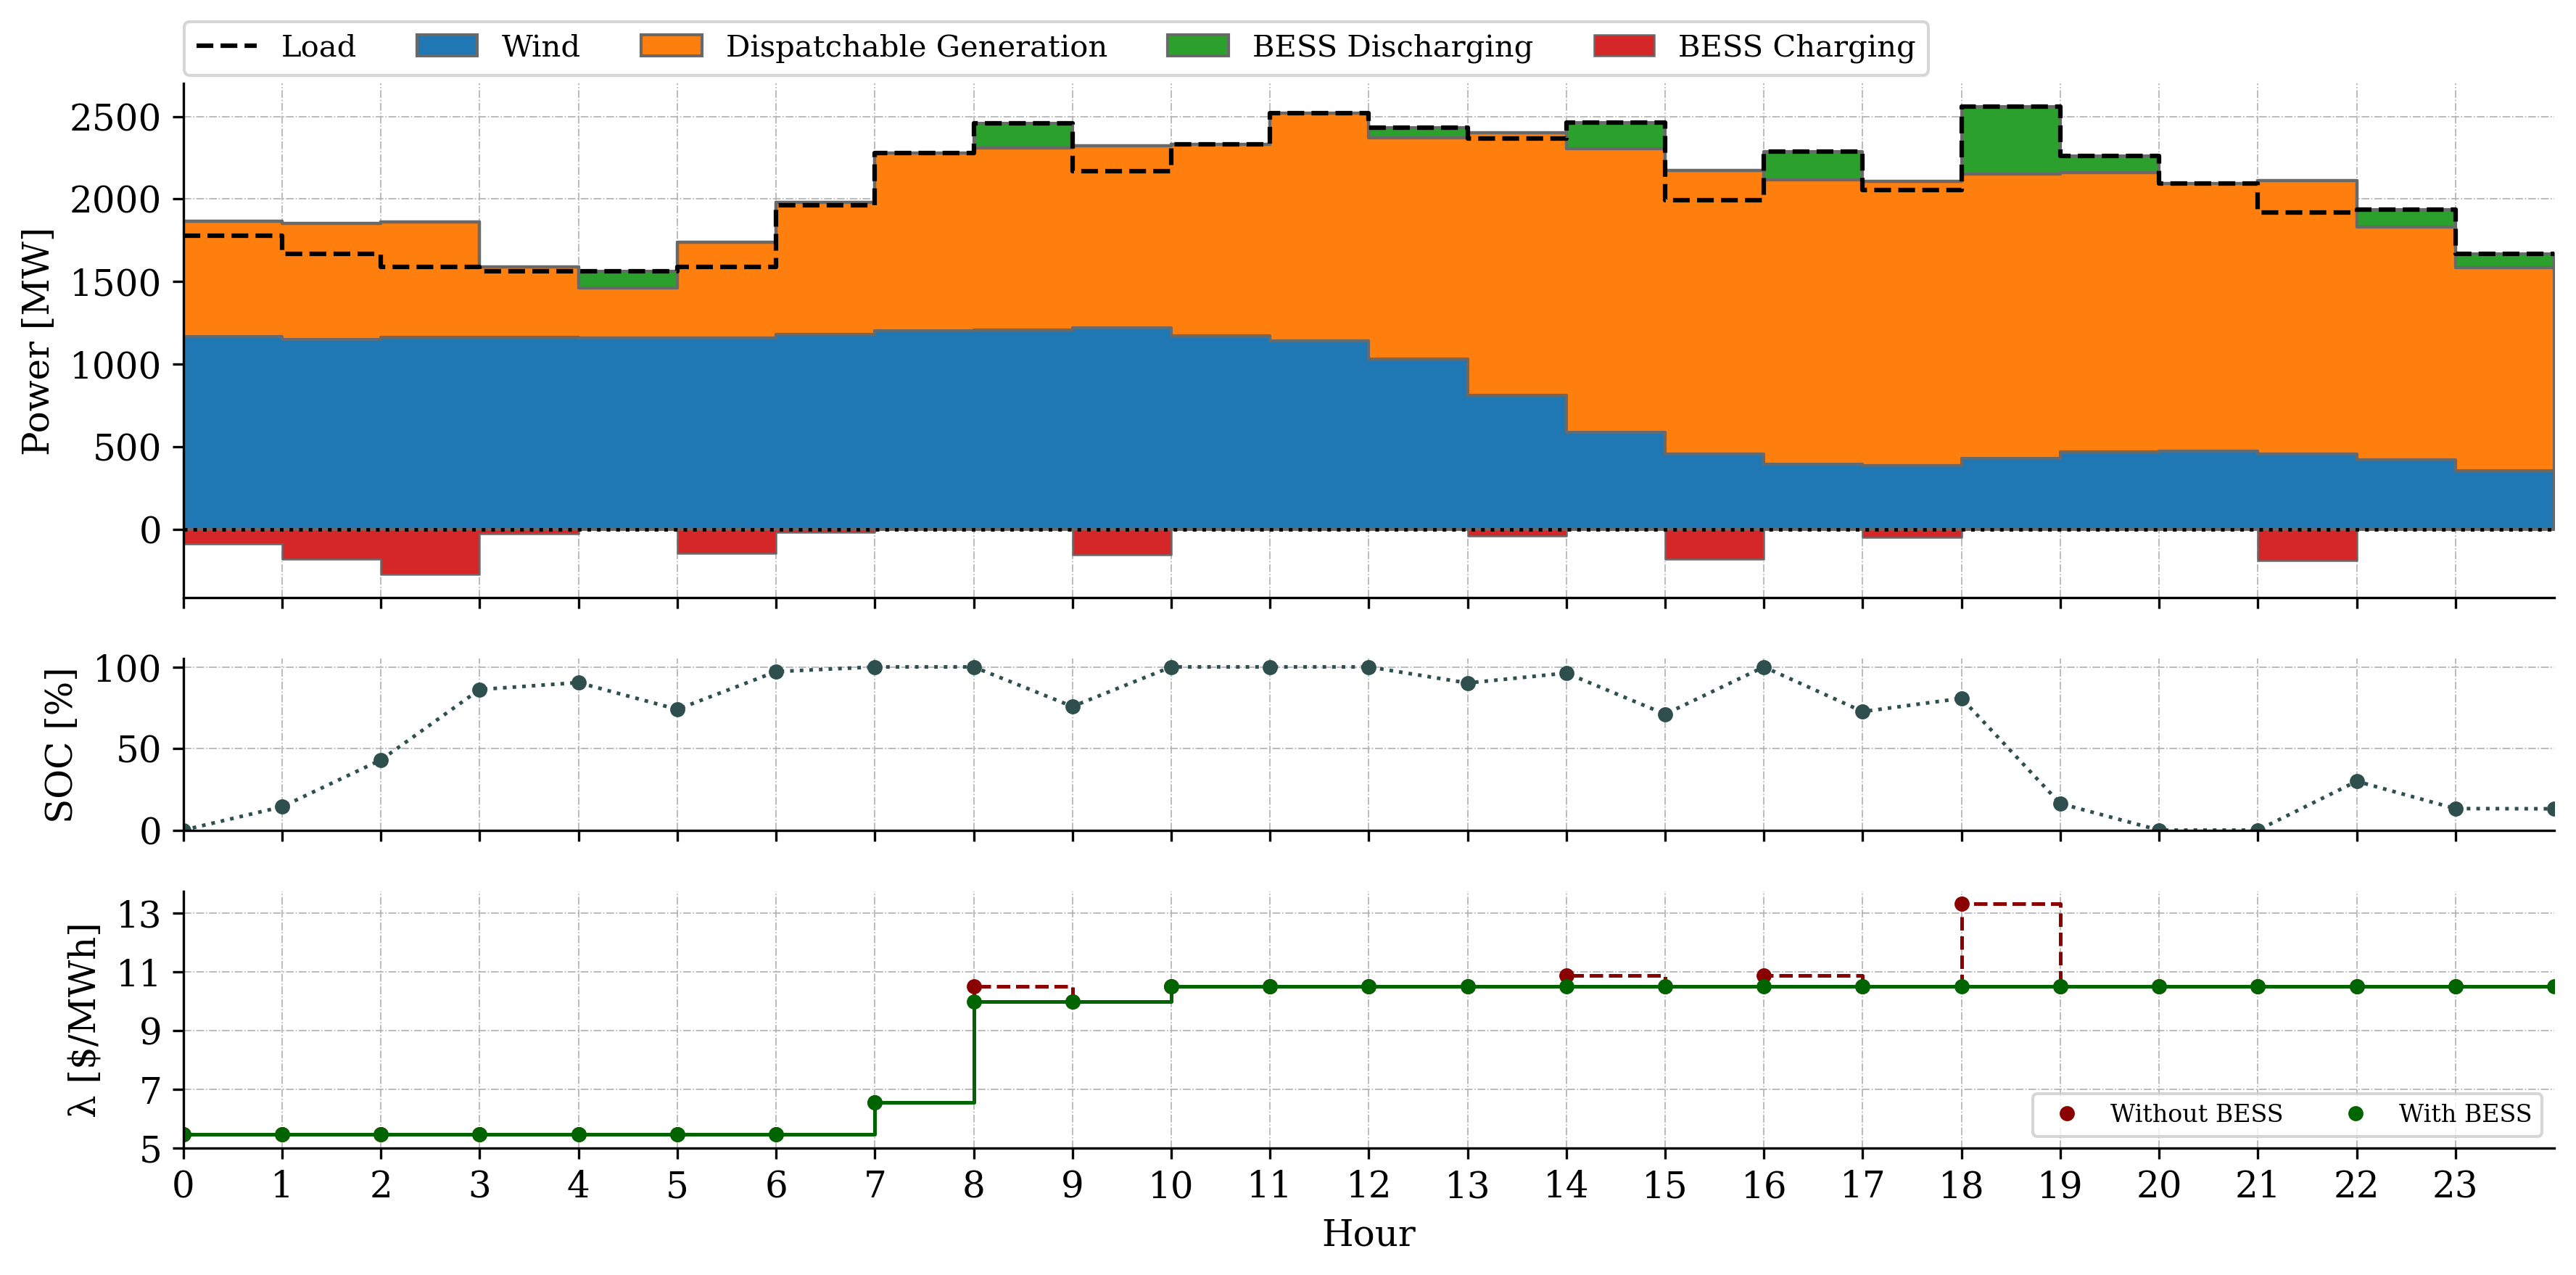

In [41]:
fig, ax = plt.subplots(3,1,sharex=True,figsize=( 12 , 6 ) , dpi=300, gridspec_kw={'height_ratios': [3, 1, 1.5]}) # Create the figure

df = results.get('overview').copy(deep=True)
df_no_BESS = results_no_BESS.get('overview').copy(deep=True)

#make a final dummy row to include the final hour in the plot
df = pd.concat([df, df.iloc[-1].to_frame().T], ignore_index=True)
df.iloc[-1, 0] = T + 1
df.iloc[-1, -1] = (df.iloc[-2, -1] + eta_bess * (df.iloc[-2, -4] - df.iloc[-2, -3]) / (B * SOC_max)) #update the SOC to the final SOC

#Plotting
ax[0].step(df.index, df['Load [MWh]'], where='post', color='black', label='Load', linestyle='--')

ax[0].stackplot(df.index, df[['Wind [MWh]', 'Dispatchable Production [MWh]', 'BESS Discharging [MWh]']].T, 
                    step='post', edgecolor='dimgrey', labels=['Wind', 'Dispatchable Generation', 'BESS Discharging'], colors=['tab:blue', 'tab:orange', 'tab:green'])

ax[0].stackplot(df.index, -1 * df['BESS Charging [MWh]'].T, step='post', edgecolor='dimgrey', labels=['BESS Charging'], linewidth=0.6, colors=['tab:red'])

ax[0].axhline(0, color='black', linewidth=1.2, linestyle=':')

ax[0].set_ylabel('Power [MW]')
ax[0].legend(loc='upper left', bbox_to_anchor=(-0.006, 1.15),ncol=5, fontsize=10)

ax[1].plot(df.index, df[r'Aggregated BESS SOC [%]'], linestyle=':', color='darkslategrey', linewidth=1.2)
ax[1].plot(df.index, df[r'Aggregated BESS SOC [%]'], linestyle='', marker='o', markersize=4, color='darkslategrey')
ax[1].set_ylabel('SOC [%]')
ax[1].set_ylim([0,105])
ax[1].set_yticks(np.arange(0, 105, 50))

#Lambda without BESS
ax[2].step(df_no_BESS.index, df_no_BESS['Lambda [$/MWh]'], linestyle='--', color='darkred', linewidth=1.2, where='post')
ax[2].plot(df_no_BESS.index, df_no_BESS['Lambda [$/MWh]'], linestyle='', marker='o', markersize=4, color='darkred', label='Without BESS')

#Lambda with BESS
ax[2].step(df.index, df['Lambda [$/MWh]'], linestyle='-', color='darkgreen', linewidth=1.2, where='post')
ax[2].plot(df.index, df['Lambda [$/MWh]'], linestyle='', marker='o', markersize=4, color='darkgreen', label='With BESS')

ax[2].set_ylabel('\u03bb [$/MWh]')
ax[2].set_ylim([5, 13.75])
ax[2].set_yticks(np.arange(5, 14 + 1, 2))
ax[2].legend(loc='lower right',ncol=2, fontsize=8)


ax[2].set_xticks(np.arange(0,T))
#ax[2].set_xticklabels(np.arange(1,T+1))
ax[2].set_xlabel('Hour')
ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)
ax[2].set_axisbelow(True)
ax[0].margins(x=0)

fig.tight_layout() # reduces white space around figures
plt.savefig('Figures/task_2_multihour_market_clearing.png',bbox_inches='tight')
plt.show()

### Hourly generator dispatches

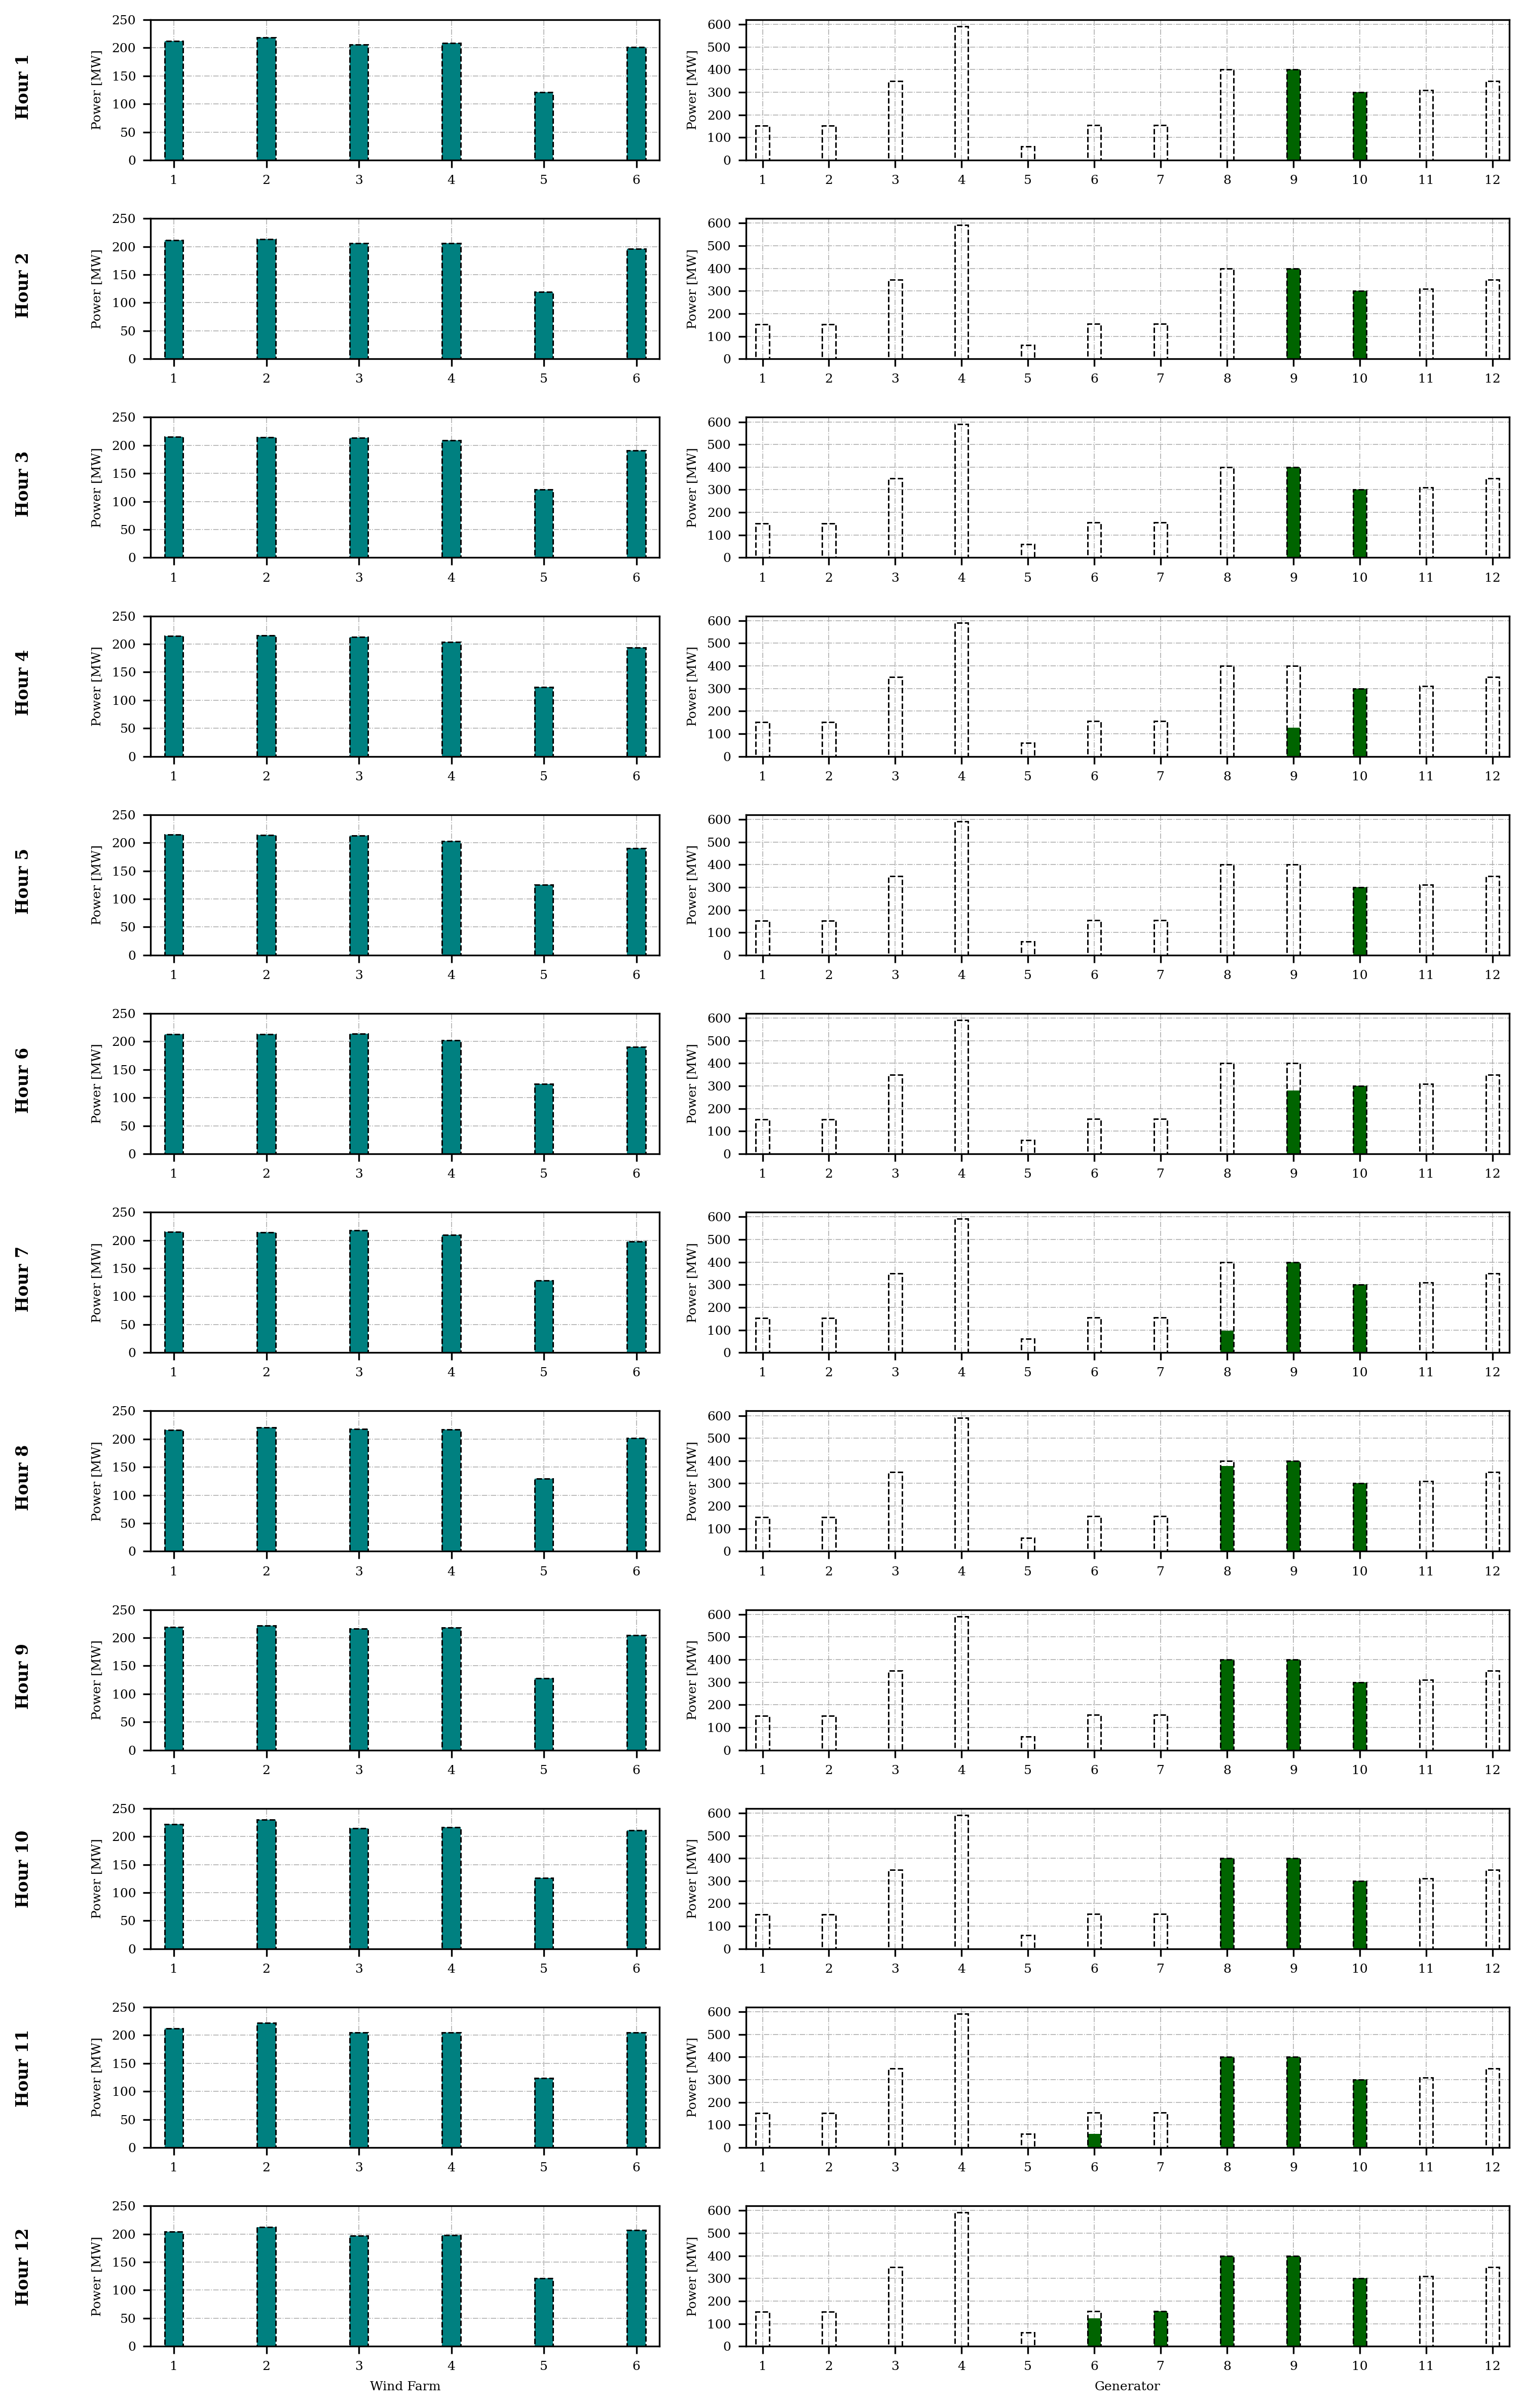

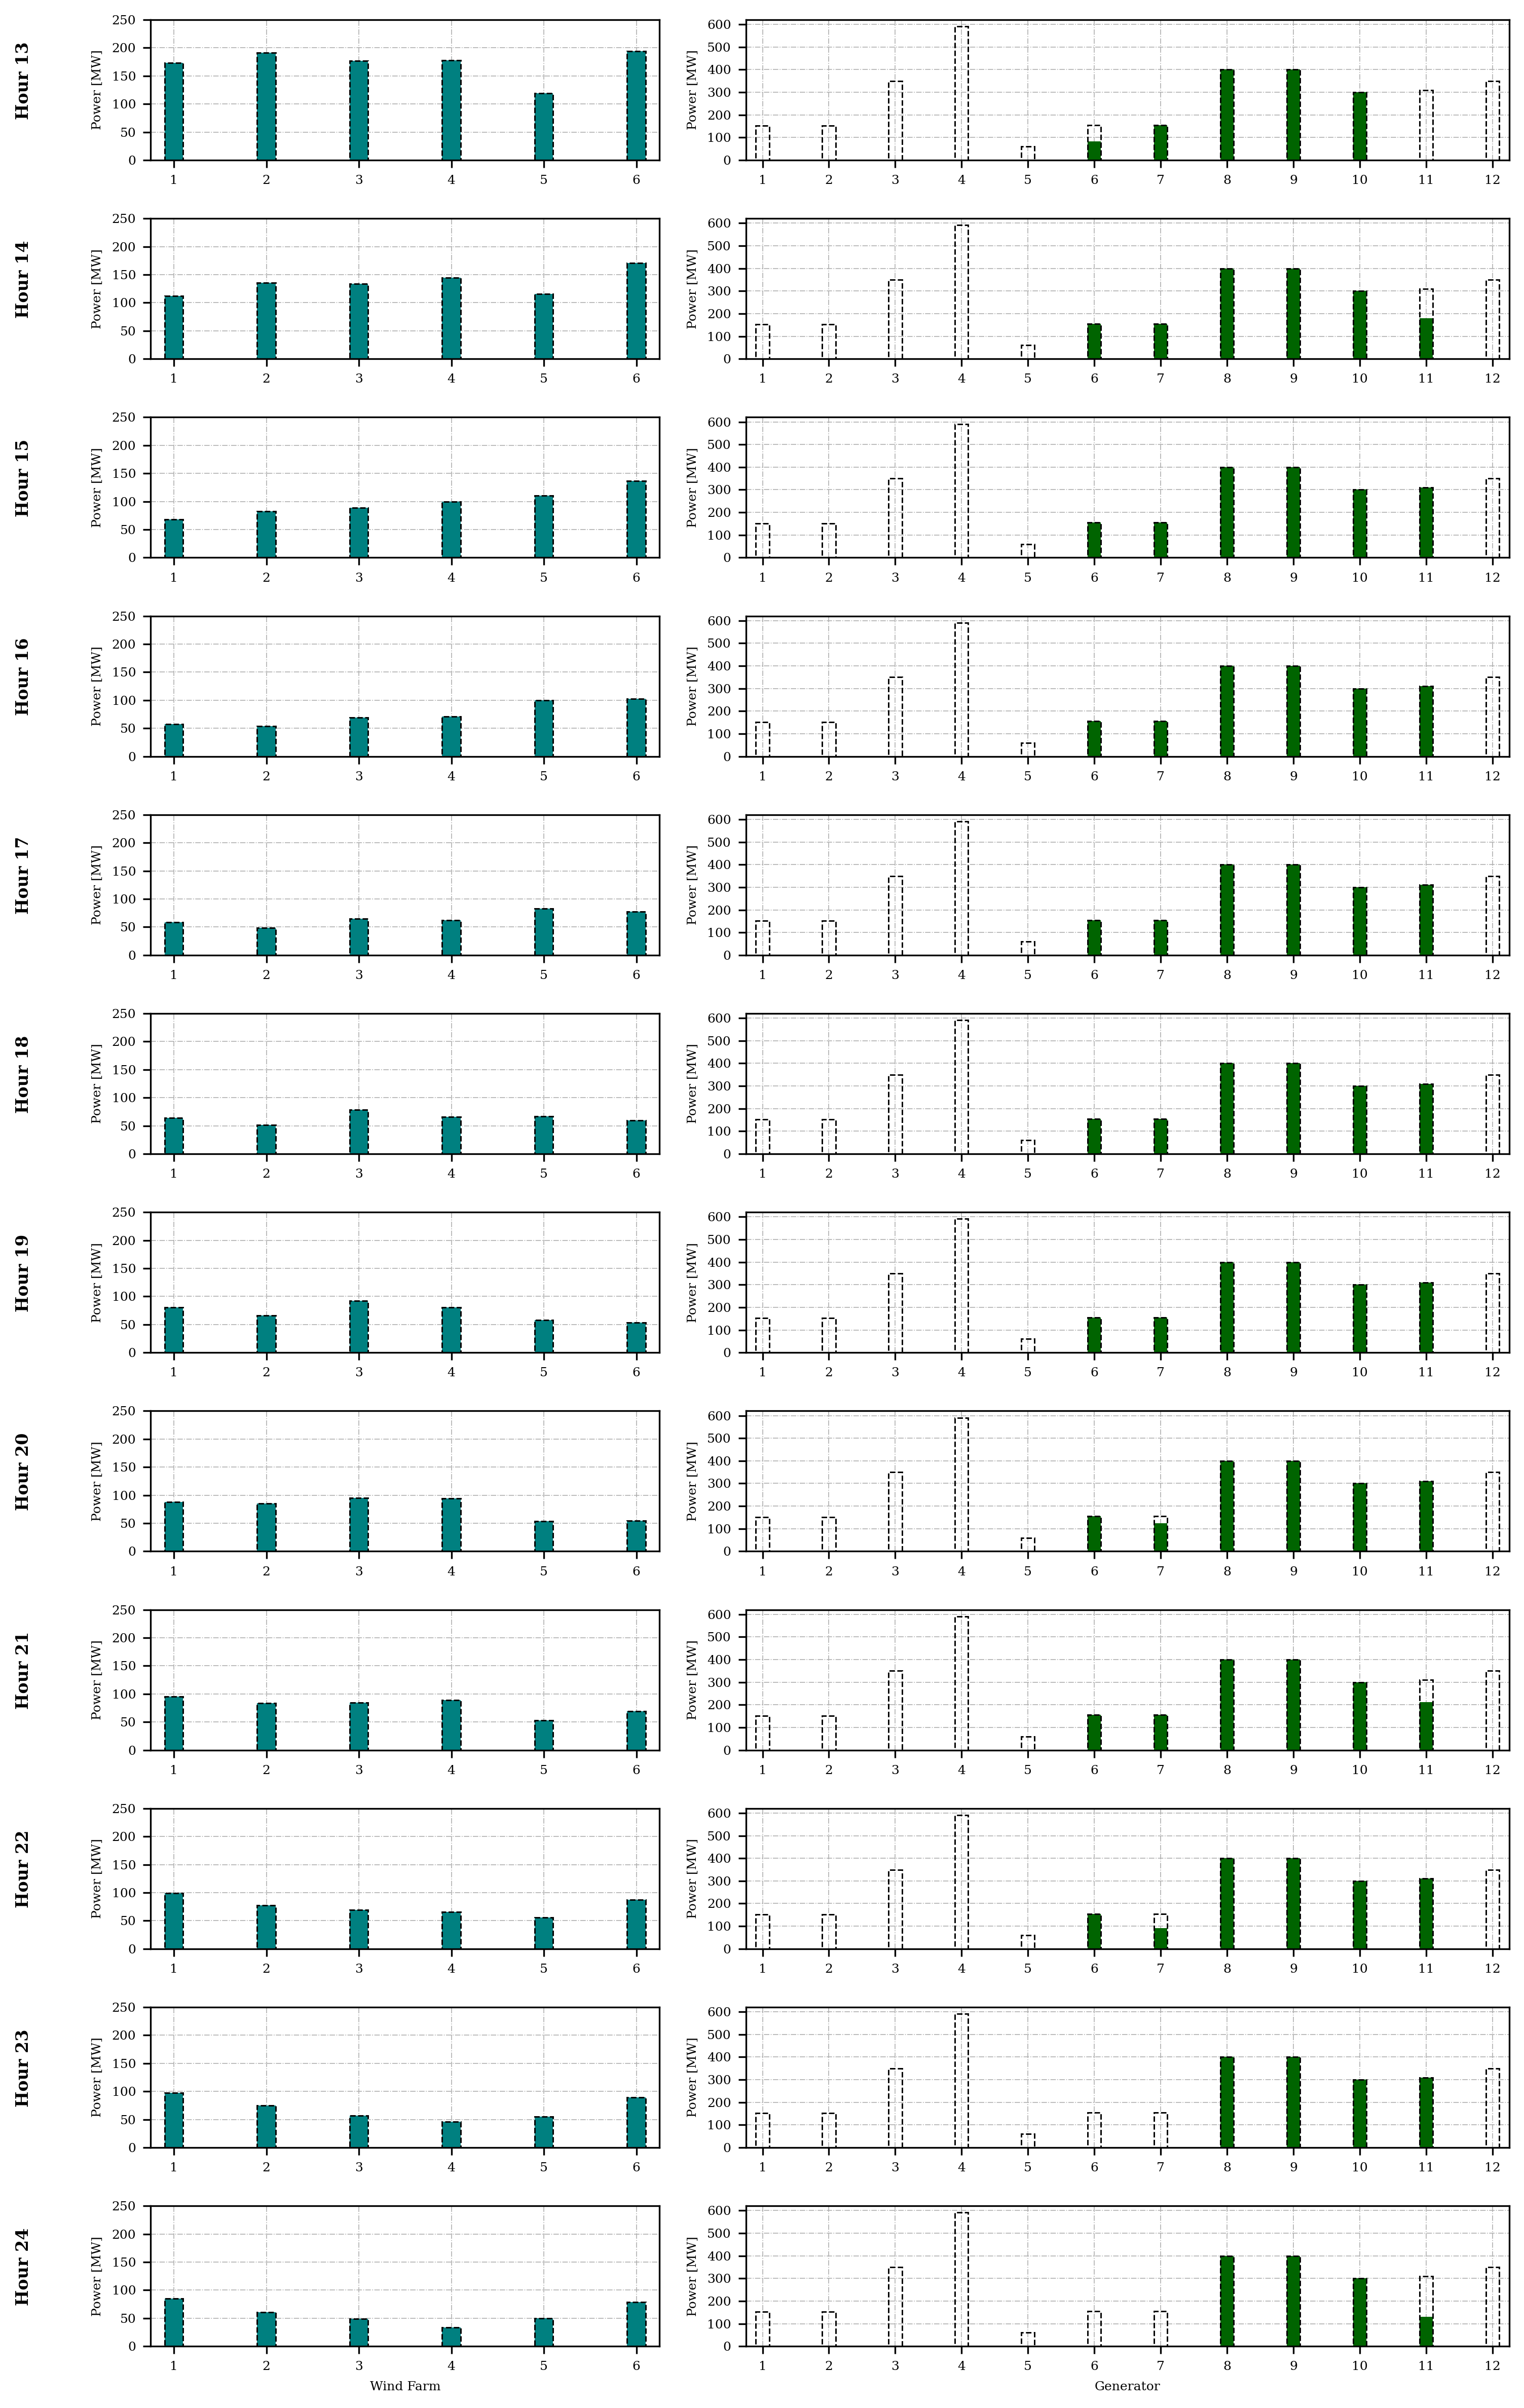

In [36]:
hours_per_plot = 12
for p in range(2): #two plots
    fig, ax = plt.subplots(12,2,figsize=( 10 , 16 ) , dpi=300, gridspec_kw={'width_ratios': [2, 3]}) # Create the figure
    offset = p * hours_per_plot
    for t in range(0 + offset, offset + hours_per_plot):
        generator_outputs = results[t].get('gen')

        (generator_outputs.loc[generator_outputs.Type == 'Wind','p_G']).plot(kind='bar', ax=ax[t - offset][0], color='teal', width=0.2)
        (wind_data.T[t].reset_index(drop=True)).plot(kind='bar', ax=ax[t - offset][0], color='black', width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=0.7, label='_nolegend_')

        ax[t - offset][0].set_ylabel('Power [MW]', fontsize=6)
        ax[-1][0].set_xlabel('Wind Farm', fontsize=6)
        ax[t - offset][0].set_xticks(ticks = np.arange(0, len(wind_data.columns)), labels = np.arange(1, len(wind_data.columns) + 1), fontsize=6, rotation = 0)
        ax[t - offset][0].set_ylim([0,250])
        ax[t - offset][0].set_yticks(np.arange(0,250 + 50, 50))
        ax[t - offset][0].set_yticklabels(np.arange(0,250 + 50, 50), fontsize=6)
        ax[t - offset][0].set_xlim([-0.25,5.25])

        #Edge alignment with negative width makes them align with right edge instead of left
        (generator_outputs.loc[generator_outputs.Type == 'Conventional','p_G']).plot(kind='bar', ax=ax[t - offset][1], color='darkgreen', width=-0.2)
        (gen_data['P max MW']).plot(kind='bar', ax=ax[t - offset][1], color='black', width=-0.2, edgecolor='black', linestyle='--', fill=False, linewidth=0.7)

        ax[t - offset][1].set_ylabel('Power [MW]', fontsize=6)
        ax[-1][1].set_xlabel('Generator', fontsize=6)
        ax[t - offset][1].set_xticks(ticks = np.arange(0, len(gen_data)), labels = np.arange(1, len(gen_data) + 1), fontsize=6, rotation = 0)
        ax[t - offset][1].set_yticks(np.arange(0,550 + 100, 100))
        ax[t - offset][1].set_yticklabels(np.arange(0,550 + 100, 100), fontsize=6)
        ax[t - offset][1].set_xlim([-0.25,11.25])

        ax[t - offset][0].set_title('Hour %d' % (t+1), fontsize=8, weight='bold', rotation='vertical', x=-0.25, y=0.225, horizontalalignment='center')

        for i in range(2):
            ax[t - offset][i].spines[['right', 'top']].set_visible(True)
            ax[t - offset][i].set_axisbelow(True)

    fig.tight_layout() # reduces white space around figures
    plt.savefig('Figures/multi_timestep_results_dispatches_part_%d.png' % (p + 1),bbox_inches='tight')
    plt.show()
